In [33]:
#imports
import numpy as np
from numpy import loadtxt
import pylab as pl
from IPython import display
from RcTorchPrivate import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

In [34]:
#this method will ensure that the notebook can use multiprocessing on jupyterhub or any other linux based system.
try:
    mp.set_start_method("spawn")
except:
    pass
torch.set_default_tensor_type(torch.FloatTensor)
%matplotlib inline

In [35]:
#helper functions
def pltTr(x,y,clr='cyan', mark='o'):
    plt.plot(x.detach().numpy(), y.detach().numpy(),
             marker=mark, color=clr, markersize=8, label='truth', alpha = 0.9)

def pltPred(x,y,clr='red', linS='-'):
    plt.plot(x.detach().numpy(), y.detach().numpy(),
             color=clr, marker='.', linewidth=2, label='RC')
from decimal import Decimal

def convert2pd(tensor1, tensor2):
    pd_ = pd.DataFrame(np.hstack((tensor1.detach().cpu().numpy(), tensor2.detach().cpu().numpy())))
    pd_.columns = ["t", "y"]
    return pd_
'%.2E' % Decimal('40800000000.00000000000000')

def reparam(t, order = 1):
    exp_t = torch.exp(-t)
    
    derivatives_of_g = []
    
    g = 1 - exp_t
    
    #0th derivative
    derivatives_of_g.append(g)
    
    g_dot = 1 - g
    return g, g_dot

In [36]:
#def force(X, A = 0):
#    return torch.zeros_like(X)
def force(X, A = 0):
    return torch.zeros_like(X)

In [37]:
torch.rand(100).std()

tensor(0.2754)

In [38]:
a = torch.linspace(0,10,500)
slope = a[-1] - a[0]
slope
#b = a[0] - slope * x[0]
#y = mx+b
#y-mx = b

tensor(10.)

In [39]:
def H(x, y, px, py):
    xsq, ysq = x**2, y**2
    LHt1 = 0.5*(px**2 + py**2)
    LHt2 = 0.5*(xsq + ysq)
    LHt3 = xsq*y - (y**3)/3
    LH = LHt1 + LHt2 + LHt3
    return(LH)


def hennon_hailes_loss(X , y, ydot, out_weights, force = force, 
                reg = True, ode_coefs = None, mean = True,
               enet_strength = None, enet_alpha = None, init_conds = None, lam = 1):
    
    

    #4 outputs
    assert init_conds

    x, y, px, py = [y[:,i].view(-1,1) for i in range(y.shape[1])]#, y[:,1].view(-1,1)
    dx, dy, dpx, dpy = [ydot[:,i].view(-1,1)for i in range(ydot.shape[1])]

    x0, y0, px0, py0 = init_conds

    xsq, ysq = x**2, y**2
    
    #with paramization
    term1 = (dx - px)**2 
    term2 = (dy - py)**2
    term3 = (dpx + x + 2*x*y)**2 
    term4 = (dpy + y + xsq - ysq )**2
    
    for i, element in enumerate([term1, term2, term3, term4]):
        assert not torch.isnan(element.mean()), f'ii {i}'
    L = (term1 + term2 + term3 + term4).mean().pow(2) 
    
    #L = L + 0.001 * ((1/torch.mean(dpx[dpx < 0.01])).pow(2)) + (1/torch.mean(dpy[dpy < 0.01]).pow(2)))

    
    #hamiltonian regularization
    #n = 10
    #rand_indexes = torch.randint(0, len(X), (n,))
    #rand_indexes = rand_indexes +  [0, -1]
    LH_ = H(x, y, px, py)
    #end = H(x[-2], y[-2], px[-2], py[-2])
    lenX = len(X)
    #for i, idx in enumerate(rand_indexes):
    LH0 = H(x0, y0, px0, py0)
    
    L_H = ((LH_ -LH0).mean()).pow(2)# + ((LH0 -end).mean()).pow(2)
    
    L = L + 0.5*L_H
    #assert L >0, f'{L}'


    #if reg:
    weight_size_sq = torch.mean(torch.square(out_weights))
    weight_size_L1 = torch.mean(torch.abs(out_weights))
    L_reg = enet_strength*(enet_alpha * weight_size_sq + (1- enet_alpha) * weight_size_L1)
    L = L + 0.1 * L_reg 
    
    return L

In [40]:
lineW = 3
lineBoxW=2


def plot_result(esn, xtrain, v0s = [1], y0s = [1], plot_gt = True, loglog = False,
               ode_coefs = None, force_k = 0, fileName=None, backprop_f = None, ax = None,
               solve = None , out_weights = None, epochs = None, init_conds = None):
    RC = esn
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (8, 6))       
    t_pow = 0
    for i, v0 in enumerate(v0s):
        y0 = y0s[i]
        
        
        train_args = {"burn_in" : int(BURN_IN), 
                      "ODE_order" : 1,
                      "force" : force,
                      "reparam_f" : reparam,
                      "init_conditions" : [0.3, -0.3, 0.3, 0.15], #[float(y0), float(v0)],
                      "ode_coefs" : ode_coefs,
                      "y" : None,
                      "X" : xtrain.view(-1,1),
                      "eq_system" : True,
                      #"init_conds" : init_conds
                      #"out_weights" : out_weights
                      }
        
        if not i:
            y, ydot = esn.fit(**train_args, SOLVE = solve, out_weights = out_weights)
            
            ode_coefs_copy = ode_coefs.copy()
            states_dict = {"s"  : RC.states.clone(),
                           "s1" : RC.states_dot.clone(), 
                           "G"  : RC.G,
                           "ex" : RC.extended_states.clone(),
                           "sb1": RC.sb1,
                           "sb" : RC.sb
                           }
            if esn.ODE_order == 2:
                            states_dict["s2"] = RC.states_dot2.clone()
                            states_dict["sb2"] = RC.sb2.clone()
            #t2 = time.perf_counter()
        else:
            y, ydot = RC.fit(preloaded_states_dict = states_dict, SOLVE = solve, 
                             **train_args, out_weights = out_weights)
        if not out_weights:
            if backprop_f:
                weight_dict = backprop_f(esn, epochs = epochs)
                y, ydot = weight_dict["y"], weight_dict["ydot"]#esn.fit(**train_args, out_weights = weight_dict, SOLVE = False)
                esn = weight_dict["RC"]
        ode_coefs_copy = ode_coefs.copy()
        if ode_coefs[0] == "t**2":
            sp = esn.X**2
            t_pow = 2
            ode_coefs_copy[0] = sp
            
        def f(u, t):
            x, y, px, py = u      # unpack current values of u
            derivs = [px, py , -(x +2*x*y), -(y + x**2 - y**2) ]     # you write the derivative here
            return derivs
        #pendulum: -np.sin(x)+A*np.sin(W*t)]
        # Scipy Solver   
        def hennon_hailes(t, u0):
            # Call the ODE solver
            solPend = odeint(f, u0, t)
            xP, yP, pxP, pyP = [solPend[:,i] for i in range(solPend.shape[1])]#       pxP = solPend[:,1];   
            return xP, yP, pxP, pyP

        init_conds = [0.3, -0.3, 0.3, 0.15]
        p = y[:,1].cpu().detach()# + v0
        yy = y[:,0].cpu().detach()# + y0
        X = esn.X.cpu().detach()

        x_gt, y_gt, px_gt, py_gt  = hennon_hailes(X.squeeze().data,init_conds) 

        if y0==1:
            extraWidth = 2; color = 'k'
        else: extraWidth=0; color = 'b'
        
        if not i:
            ax.plot(X, yy, color, linewidth=lineW+extraWidth, label = "x_hat", color = "blue" )
            ax.plot(X, p, color, linewidth=lineW+extraWidth, label = "y_hat", color = "red" )
           
            #ax.plot(X, torch.cos(X),'--', linewidth=lineW, alpha=0.85, label = "p_gt", color = "red")
            #ax.plot(X, torch.sin(X),'--', linewidth=lineW, alpha=0.85, label = "x_gt", color = "blue")
            
            ax.plot(X, x_gt,'--', linewidth=lineW, alpha=0.85, label = "x_gt_", color = "red")
            ax.plot(X, y_gt,'--', linewidth=lineW, alpha=0.85, label = "y_gt_", color = "blue")
        else:
            ax.plot(X, yy, color, linewidth=lineW+extraWidth, color = "blue")
            ax.plot(X, p,'--r', linewidth=lineW, alpha=0.85, color = "red")
            
            ax.plot(X, x_gt,'--', linewidth=lineW, alpha=0.85, color = "red")
            ax.plot(X, y_gt,'--', linewidth=lineW, alpha=0.85, color = "blue")
        
        ## Formating Figure
        # Changing spine style
        ax = plt.gca()
        for ps in ['top','bottom','left','right']:
            ax.spines[ps].set_linewidth(lineBoxW)

        plt.xlabel(r'$t$')
        plt.ylabel(r'$y(t)$')
        plt.legend()
        
    return esn

def H(x, y, px, py):
    xsq, ysq = x**2, y**2
    LHt1 = 0.5*(px**2 + py**2)
    LHt2 = 0.5*(xsq + ysq)
    LHt3 = xsq*y - (y**3)/3
    LH = LHt1 + LHt2 + LHt3
    return(LH)


global lr_100_epoch
global lr_1000_epoch
global lr_5000_epoch

lr_100_epoch, lr_1000_epoch, lr_5000_epoch = [], [], []        
    
def optimize_last_layer(esn, 
                        SAVE_AFTER_EPOCHS = 1000,
                        epochs = 45000,
                        custom_loss = hennon_hailes_loss,
                        loss_threshold = 10**-25,#10**-4,#10 ** -8,
                        EPOCHS_TO_TERMINATION = None,
                        f = force,
                        lr = 0.1, 
                        reg = None,
                        plott = True, gamma = None, spikethreshold = None,
                        plot_every_n_epochs = 2000, gamma_cyclic = None):#gamma 0.1, spikethreshold 0.07 works
    #define new_x
    new_X = esn.extended_states.detach()

    #force detach states_dot
    esn.states_dot = esn.states_dot.detach().requires_grad_(False)

    #define criterion
    criterion = torch.nn.MSELoss()

    #assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
    #assert not new_X.requires_grad

    #define previous_loss (could be used to do a convergence stop)
    previous_loss = 0

    #define best score so that we can save the best weights
    best_score = 0

    #define the optimizer
    optimizer = optim.Adam(esn.parameters(), lr = lr)
    
    #optimizer = torch.optim.SGD(model.parameters(), lr=100)
    if esn.gamma_cyclic:
        cyclic_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 0.001, 0.0001,
                                          gamma = esn.gamma_cyclic,#0.9999,
                                          mode = "exp_range", cycle_momentum = False, step_size_up=1000,)
        
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=esn.gamma)
    lrs = []

    #define the loss history
    loss_history = []
    
    if plott:
        #use pl for live plotting
        fig, ax = pl.subplots(1,3, figsize = (16,4))
    
    t = esn.X#.view(*N.shape).detach()
    g, g_dot = esn.G
    y0  = esn.init_conds[0]
    
    flipped = False
    flipped2 = False
    pow_ = -4
    floss_last = 0
    
    
    try:
        assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
    except:
        esn.LinOut.weight.requires_grad_(True)
        esn.LinOut.bias.requires_grad_(True)
        
    #bail
    
    #begin optimization loop
    for e in range(epochs):

        optimizer.zero_grad()
        
        N = esn.forward( esn.extended_states )
        N_dot = esn.calc_Ndot(esn.states_dot)

        y = g *N 
        
        ydot = g_dot * N + g * N_dot
        
        for i, cond in enumerate(esn.init_conds):
            y[:,i] = y[:,i] + cond
        

        assert N.shape == N_dot.shape, f'{N.shape} != {N_dot.shape}'
        
        #assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad

        #total_ws = esn.LinOut.weight.shape[0] + 1
        #weight_size_sq = torch.mean(torch.square(esn.LinOut.weight))
        
        loss = custom_loss(esn.X, y, ydot, esn.LinOut.weight, reg = reg, ode_coefs = esn.ode_coefs,
                          init_conds = esn.init_conds, enet_alpha= esn.enet_alpha, enet_strength = esn.enet_strength)
        loss.backward()
        optimizer.step()
        if esn.gamma_cyclic and e > 500:
            cyclic_scheduler.step()
  
        lrs.append(optimizer.param_groups[0]["lr"])
        
        
        floss = float(loss)
        loss_history.append(floss)
        
        
        """
        if floss < 10**pow_ :
            scheduler.step()
            lrs.append(optimizer.param_groups[0]["lr"])
            #for param_group in optimizer.param_groups:
            #    print('lr', param_group['lr'])
            pow_ -= 1
        """
#       if e == 10**3:
#             if floss > 10**(-4):
#                 EPOCHS_TO_TERMINATION = e + 50
        
#         if e == 10**4:
#             if floss > 10**(2.5):
#                 EPOCHS_TO_TERMINATION = e + 50
        if e > 0:
            
            loss_delta = float(np.log(floss_last) - np.log(floss)) 
            if loss_delta > esn.spikethreshold:# or loss_delta < -3:
                lrs.append(optimizer.param_groups[0]["lr"])
                scheduler.step()
            
        
#         quant = 0.8
#         if e == 100:
#             lr_100_epoch.append(floss)
#             if floss >= np.quantile(np.array(lr_100_epoch), 0.8):
#                 if len(lr_100_epoch) > 20:
#                     EPOCHS_TO_TERMINATION = e + 50
#         elif e == 1000:
#             lr_1000_epoch.append(floss)
#             if floss >= np.quantile(np.array(lr_1000_epoch), 0.8):
#                 if len(lr_100_epoch) > 20:
#                     EPOCHS_TO_TERMINATION = e + 50
#         if e == 5000:
#             lr_5000_epoch.append(floss)
#             if floss >= np.quantile(np.array(lr_5000_epoch), 0.8):
#                 if len(lr_100_epoch) > 20:
#                     EPOCHS_TO_TERMINATION = e + 50
        
        
        if not e and not best_score:
            best_bias, best_weight, best_fit = esn.LinOut.bias.detach(), esn.LinOut.weight.detach(), y

        if e > SAVE_AFTER_EPOCHS:
            if not best_score:
                
                if floss <= min(loss_history):
                    best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
                    best_score = float(loss)
            else:
                if floss < best_score:
                    best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
                    best_score = float(loss)
                    
        if not EPOCHS_TO_TERMINATION:
            if float(loss) < loss_threshold:
                EPOCHS_TO_TERMINATION = e + 100
        else:
            if e >= EPOCHS_TO_TERMINATION:
                if not best_score:
                    best_score = float(loss)
                return {"weights": best_weight, "bias" : best_bias, "y" : y, "ydot" : ydot,
                        "loss" : loss_history, "best_score" : torch.tensor(best_score),
                        "RC" : esn}
        floss_last = floss
        if plott and e:

            if e % plot_every_n_epochs == 0:
                
                
                ax[0].clear()
                for param_group in optimizer.param_groups:
                    lr_ = param_group['lr']
                    break
                #print('gc',esn.gamma_cyclic, "lr")
                logloss_str = 'Log(L) ' + '%.2E' % Decimal((loss).item())
                delta_loss  = ' delta Log(L) ' + '%.2E' % Decimal((loss-previous_loss).item())

                print(logloss_str + ", " + delta_loss)
                ax[0].plot(y.detach().cpu(), label = "exact")
                ax[0].set_title(f"Epoch {e}" + ", " + logloss_str)
                ax[0].set_xlabel("t")

                ax[1].set_title(delta_loss)
                ax[1].plot(N_dot.detach().cpu())
                #ax[0].plot(y_dot.detach(), label = "dy_dx")
                ax[2].clear()
                #weight_size = str(weight_size_sq.detach().item())
                #ax[2].set_title("loss history \n and "+ weight_size)
                
                ax[2].set_title(str(lr_))
                ax[2].loglog(loss_history)
                ax[2].set_xlabel("t")

                [ax[i].legend() for i in range(3)]
                previous_loss = loss.item()

                #clear the plot outputt and then re-plot
                display.clear_output(wait=True) 
                display.display(pl.gcf())
            
    if not best_score:
        best_score = float(loss)

    return {"weights": best_weight, "bias" : best_bias, "y" : y, "ydot" : ydot,
                        "loss" : loss_history, "best_score" : torch.tensor(best_score),
                        "RC" : esn}



In [41]:
log_vars = ['connectivity', 'llambda', 'llambda2', 'noise', 'regularization', 'dt', 'enet_strength', 
           "gamma_cyclic"]

#trained to 20*pi
hps ={'dt': 0.01,#0.001,
 'n_nodes': 500,
 'connectivity': 0.019946997092875757,
 'spectral_radius': 2.4289157390594482,
 #'regularization': 49.04219249279563,
 'leaking_rate': 0.0032216429244726896,
 'bias': 0.3808490037918091,
 'enet_alpha': 0.2040003091096878,
 'enet_strength': 0.07488961475845243,
 'spikethreshold': 0.4231834411621094,
 'gamma': .09350859373807907,
  'gamma_cyclic' : 0.999}#10.9998}

for key, val in hps.items():
    if key in log_vars:
        print(key, np.log10(val))
    else:
        print(key, val)

dt -2.0
n_nodes 500
connectivity -1.7001224756240845
spectral_radius 2.4289157390594482
leaking_rate 0.0032216429244726896
bias 0.3808490037918091
enet_alpha 0.2040003091096878
enet_strength -1.1255784034729004
spikethreshold 0.4231834411621094
gamma 0.09350859373807907
gamma_cyclic -0.0004345117740176917


In [10]:
10**-8.686758342857122e-05

0.9998

In [11]:
BURN_IN = 500

#declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
# bounds_dict = {"connectivity" : -1.7001224756240845, 
#                "spectral_radius" : (2.4289157390594482 -0.5 , 2.4289157390594482 + 0.5),
#                "n_nodes" : 501,
#                #"regularization" : (-4.4, 2.6),
#                "leaking_rate" : (0, 0.05),
#                #"input_scaling" : (0, 1),
#                #"feedback_scaling" : (0, 1),
#                "dt" : -2,
#                "bias": 0.3808490037918091,
#                "enet_alpha":  0.2040003091096878,
#                "enet_strength": (-1.1255784034729004-0.2, -1.1255784034729004+0.2),
#                "spikethreshold" : 0.4231834411621094,
#                "gamma" : 0.09350859373807907,#(0.05,0.5),
#                "gamma_cyclic" : 0.9997#(-8.686758342857122e-05, 0)
               
#                }
bounds_dict = {"connectivity" : (-2.1, -0.5), #(-2, -0.5), 
               "spectral_radius" : (0.9, 3),#(0.01, 1),
               "n_nodes" : 250,
               "regularization" : (-4.4, 2.6),
               "leaking_rate" : (0.0001, 0.5),
               "dt" : -2,
               "bias": (-1.5,1.5),
               "enet_alpha": (0.9,1.0),
               "enet_strength": (-1.5,-0.8),
               "spikethreshold" : 0.25,#(0.01,0.65),
               "gamma" : (0.08,0.12),
               "gamma_cyclic" : (-0.002176919254274547, 0)
               
               }
#set up data
x0, xf = 0, 10*np.pi
nsteps = int(abs(xf - x0)/(10**bounds_dict["dt"]))
xtrain = torch.linspace(x0, xf, nsteps, requires_grad=False).view(-1,1)
int(xtrain.shape[0] * 0.5*0.5)

xtrain[1] - xtrain[0]

tensor([0.0100])

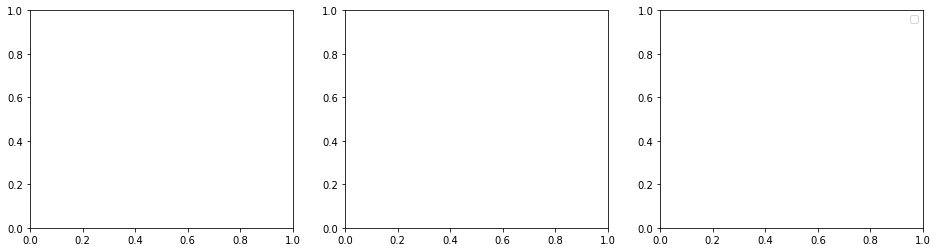

0


<ipython-input-8-29c403a3123e>:170: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = pl.subplots(1,3, figsize = (16,4))


train_score tensor(0.0069) val score tensor(0.0219)
1
train_score tensor(0.0007) val score tensor(0.0008)
2


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 17, in <module>
  File "/Users/hayden/Desktop/RcTorch-private/RcTorchPrivate/esn_cv.py", line 1589, in optimize
    Y_batch = self.eval_objective( X_batch )
  File "/Users/hayden/Desktop/RcTorch-private/RcTorchPrivate/esn_cv.py", line 996, in eval_objective
    return self.HRC(x)
  File "/Users/hayden/Desktop/RcTorch-private/RcTorchPrivate/esn_cv.py", line 1336, in HRC
    results = execute_HRC(data_args[0])
  File "/Users/hayden/Desktop/RcTorch-private/RcTorchPrivate/esn_cv.py", line 575, in execute_HRC
    weight_dict = backprop_f(RC,
  File "<ipython-input-8-29c403a3123e>", line 215, in optimize_last_layer
    loss.backward()
  File "/usr/local/anaconda3/lib/python3.8/site-packages/torch/tensor.py", line 221, in backward
    torch.autograd.backward(self, gradient, retain_graph, cre

TypeError: object of type 'NoneType' has no len()

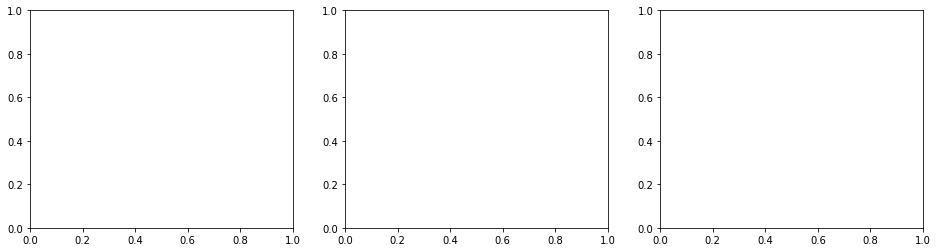

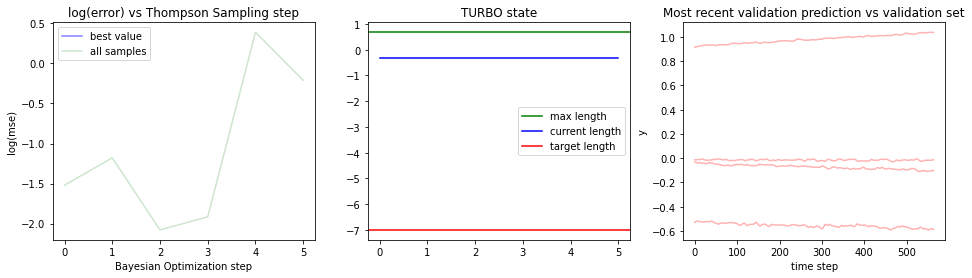

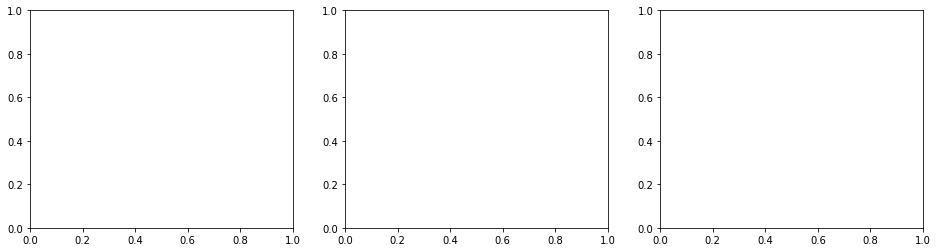

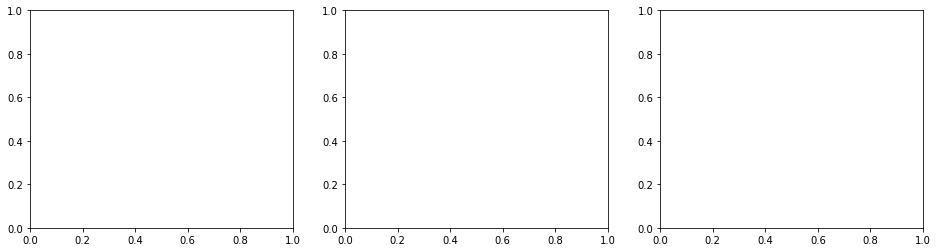

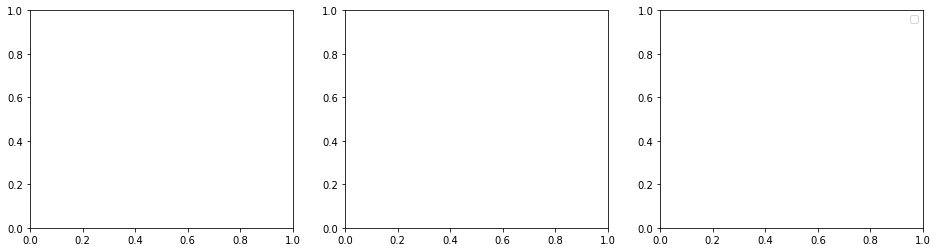

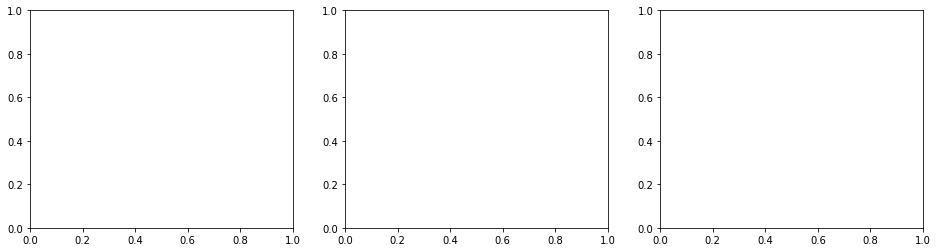

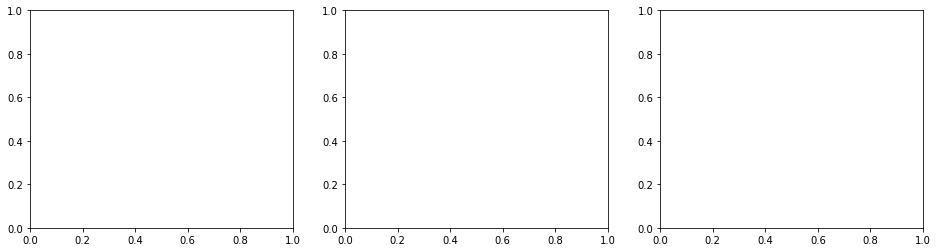

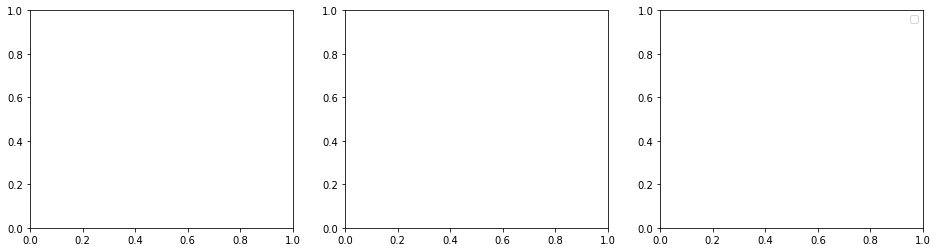

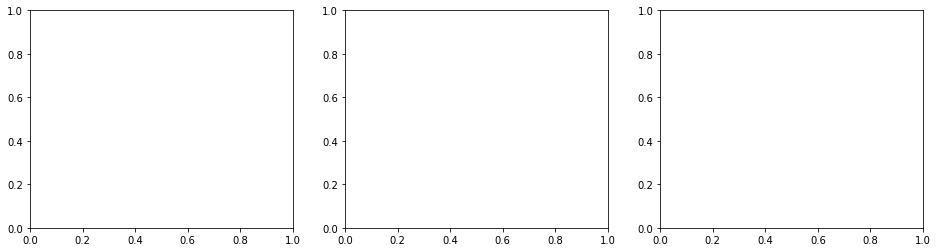

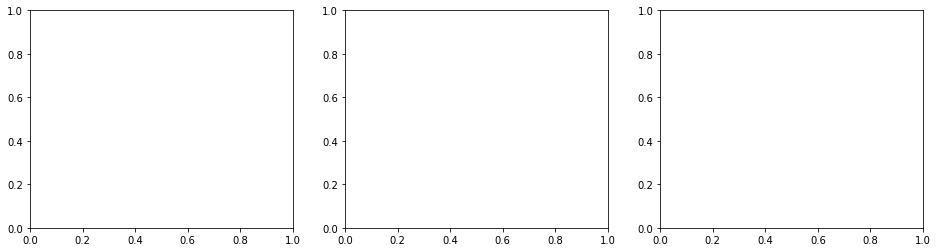

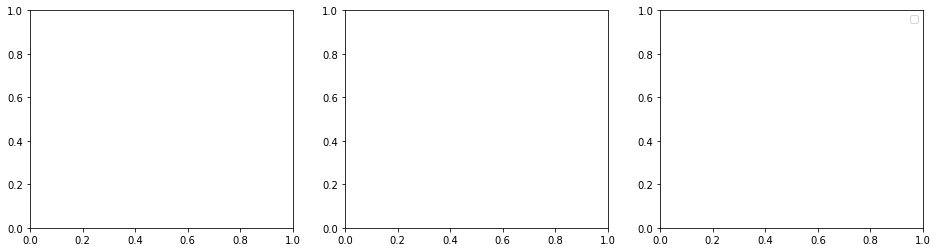

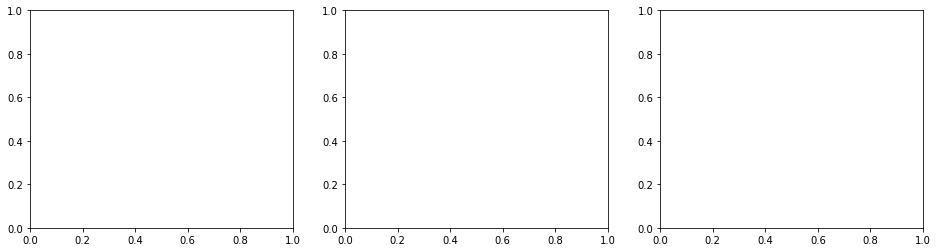

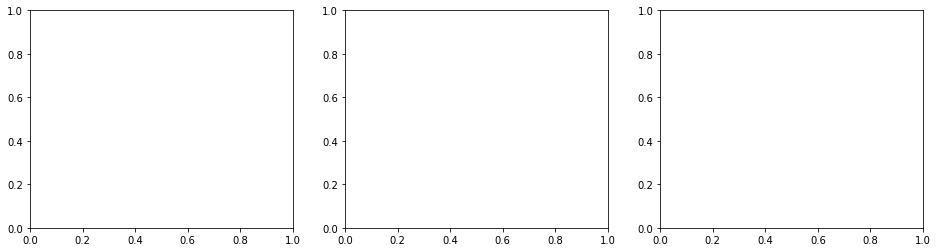

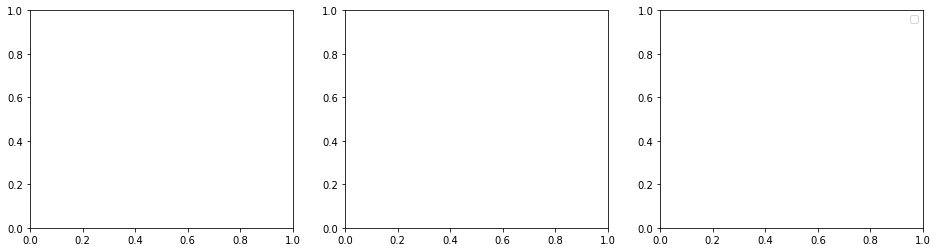

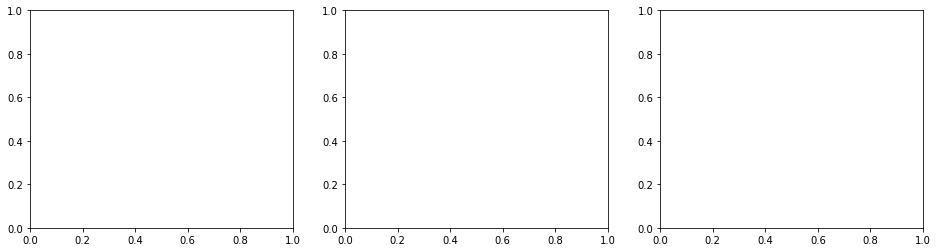

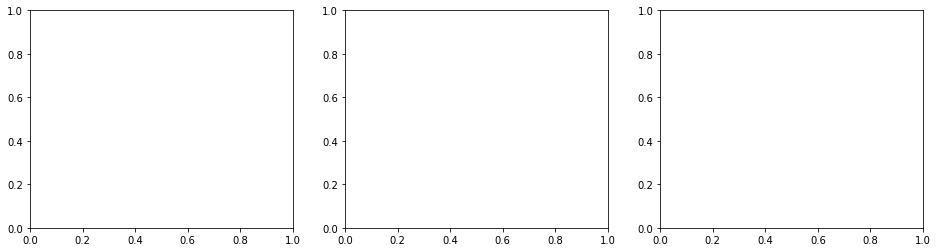

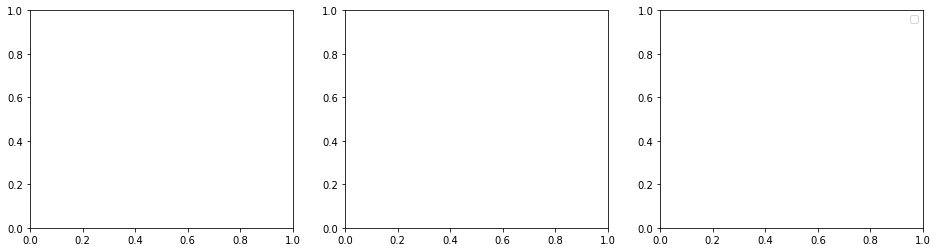

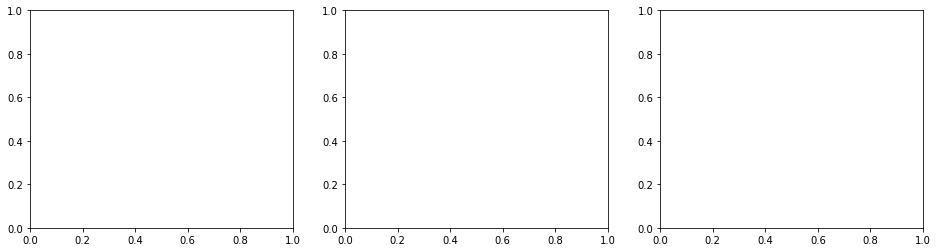

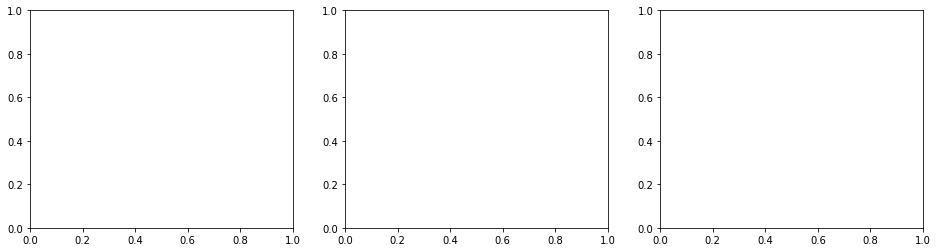

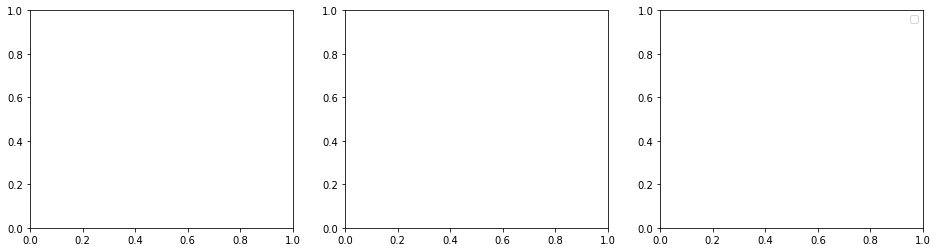

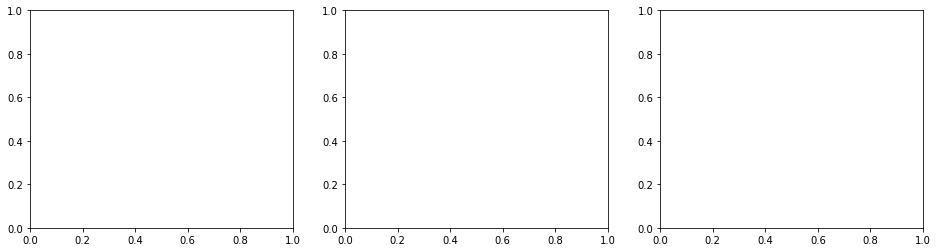

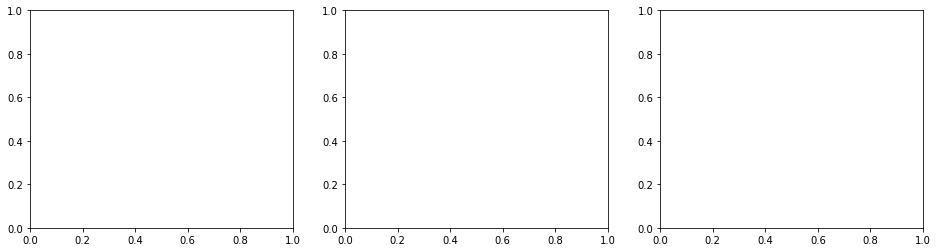

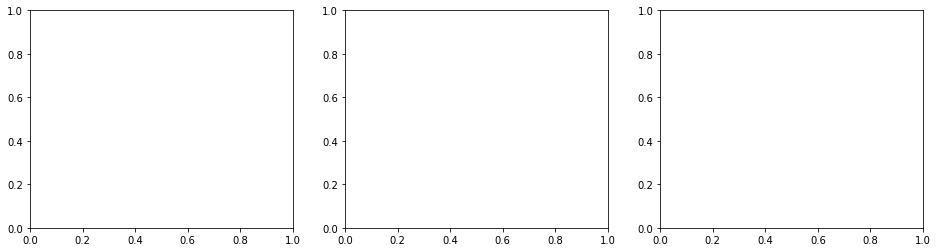

In [12]:
%%time
#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.
esn_cv = EchoStateNetworkCV(bounds = bounds_dict,
                            interactive = True, 
                            batch_size = 1, cv_samples = 3, initial_samples = 10,  #200
                            subsequence_length = int(xtrain.shape[0] * 0.6),
                            random_seed = 209, success_tolerance = 12,
                            windowsOS =False, validate_fraction = 0.3, 
                            ODE_order = 1, length_min = 2 **(-7),
                            esn_burn_in = BURN_IN, log_score = True,
                            activation_function = torch.sin,
                            act_f_prime = torch.cos
                            )
#optimize:
opt = True
w = 0.005
if opt:
    opt_hps = esn_cv.optimize(y = None, 
                            x = xtrain.view(-1,1),#.cuda(),
                            reparam_f = reparam, 
                            ODE_criterion = hennon_hailes_loss,
                            init_conditions = [0.3, -0.3, 0.3, 0.15],
                            force = force,
                            ode_coefs = [1, 1, 1, 1],
                            rounds =1,
                            backprop_f = optimize_last_layer, 
                            solve =  False, 
                            eq_system = True,
                            n_outputs = 4,
                            tr_score_prop = 0.05,
                            epochs = 1005,
                            reg_type = "hennon")
#                               [[0.3 - w, 0.3+w],
#                                                [-0.3 - w, -0.3+w],
#                                                [0.3 - w, 0.3+w],
#                                                [0.15 - w, 0.15+w]],
                              

In [42]:
def recover_params(esn_cv):
    best_vals = esn_cv.X_turbo[torch.argmax(esn_cv.Y_turbo)]
    denormed_ = esn_cv.denormalize_bounds(best_vals)
    #####Bad temporary code to change it back into a dictionary
    denormed_free_parameters = list(zip(esn_cv.free_parameters, denormed_))
    denormed_free_parameters = dict([ (item[0], item[1].item()) for item in denormed_free_parameters])

    best_hyper_parameters = denormed_free_parameters
    for fixed_parameter in esn_cv.fixed_parameters:
        best_hyper_parameters = {fixed_parameter : esn_cv.bounds[fixed_parameter], **best_hyper_parameters }

    #log_vars = ['connectivity', 'llambda', 'llambda2', 'noise', 'regularization', 'dt']
    for var in esn_cv.log_vars:
        if var in best_hyper_parameters:
            best_hyper_parameters[var] = 10. ** best_hyper_parameters[var] 

    display.clear_output() 
    display.display(pl.gcf()) 

    # Return best parameters
    return best_hyper_parameters #X_turbo, Y_turbo, state, best_vals, denormed_ #best_arguments

In [43]:
opt_hps

NameError: name 'opt_hps' is not defined

In [44]:
recover_params(esn_cv)

AttributeError: module 'RcTorchPrivate.esn_cv' has no attribute 'X_turbo'

In [45]:
esn_cv.X_turbo[torch.argmax(esn_cv.Y_turbo)]

AttributeError: module 'RcTorchPrivate.esn_cv' has no attribute 'X_turbo'

In [ ]:
esn.LinIn.weight.shape, esn.x_val.shape

In [46]:
hps = {'dt': 0.01, #0.01
 'n_nodes': 500,
 'connectivity': 0.028356255320533874,
 'spectral_radius': 1.2997043132781982,
 'regularization': 0.14243005645289958,
 'leaking_rate': 0.17017732560634613,
 'bias': -0.2719714641571045,
 'enet_alpha': 0.24579721689224243,
 'enet_strength': 0.04751602114340485,
 'spikethreshold': 0.25, #0.5769500732421875,
 'gamma': 0.5974482297897339}
hh_hps = {'dt': 0.0031622776601683794,
 'n_nodes': 500,
 'connectivity': 0.019055981540254844,
 'spectral_radius': 4.69163179397583,
 'regularization': 2.4722269747922927,
 'leaking_rate': 0.29281026124954224,
 'bias': 0.09319031238555908,
 'enet_alpha': 0.24754978716373444,
 'enet_strength': 65.7696588239509,
 'spikethreshold': 0.07966846972703934,
 'gamma': 0.1007501482963562}

may12hps = {'dt': 0.01,
 'n_nodes': 500,
 'connectivity': 0.18454977483901142,
 'spectral_radius': 4.780652046203613,
 'regularization': 12.68806696324332,
 'leaking_rate': 0.3153698146343231,
 'bias': 0.6927676200866699,
 'enet_alpha': 0.2731938064098358,
 'enet_strength': 2.320423244701488,
 'spikethreshold': 0.40845566987991333,
 'gamma': 0.5875887870788574}

may12afternoon = {'dt': 0.01,
 'n_nodes': 500,
 'connectivity': 0.13282149550084912,
 'spectral_radius': 3.1884710788726807,
 'leaking_rate': 0.5849189162254333,
 'input_scaling': 0.7250680327415466,
 'bias': -1.427717924118042,
 'enet_alpha': 0.2624272406101227,
 'enet_strength': -1.9749314785003662,
 'spikethreshold': 0.5069158673286438,
 'gamma': 0.16006392240524292}

nl_oscillator = {'dt': 0.01,#0.001,
 'n_nodes': 500,
 'connectivity': 0.019946997092875757,
 'spectral_radius': 2.4289157390594482,
 #'regularization': 49.04219249279563,
 'leaking_rate': 0.0032216429244726896,
 'bias': 0.3808490037918091,
 'enet_alpha': 0.2040003091096878,
 'enet_strength': 0.07488961475845243,
 'spikethreshold': 0.4231834411621094,
 'gamma': .09350859373807907,
  'gamma_cyclic' : 0.999}#10.9998}

may13hps = {'spikethreshold': 0.25,
 'dt': 0.001,
 'n_nodes': 600,
 'connectivity': 0.1262971933875365,
 'spectral_radius': 1.9269132614135742,
 'regularization': 0.14365491827952798,
 'leaking_rate': 0.00824384018778801,
 'bias': 1.1013243198394775,
 'enet_alpha': 0.9160057902336121,
 'enet_strength': 0.12981001236873782,
 'gamma': 0.08237317949533463,
 'gamma_cyclic': 0.9967125303312797}

#to 2pi
may13hps2 = {'spikethreshold': 0.25,
 'dt': 0.01,
 'n_nodes': 600,
 'connectivity': 0.2581061530818068,
 'spectral_radius': 1.320271372795105,
 'regularization': 0.009000893470005386,
 'leaking_rate': 0.33609646558761597,
 'bias': -0.3918585777282715,
 'enet_alpha': 0.970792829990387,
 'enet_strength': 0.09357332615779898,
 'gamma': 0.09979948401451111,
 'gamma_cyclic': 0.9984204210083131}

#to 6pi
may13hps3 = {'spikethreshold': 0.2,#0.25,
 'dt': 0.001,
 'n_nodes': 600,
 'connectivity': 0.021916331479276043,
 'spectral_radius': 1.289561152458191,
 'regularization': 0.04516064357096964,
 'leaking_rate': 0.4159146845340729,
 'bias': 0.4269450902938843,
 'enet_alpha': 0.9641867280006409,
 'enet_strength': 0.03369745249515479,
 'gamma': 0.10483698546886444,
 'gamma_cyclic': 0.9}#0.9972406129708727}

may13hps4 = {'spikethreshold': 0.25,
 'dt': 0.00630957344480193,
 'n_nodes': 600,
 'connectivity': 0.02106910408219933,
 'spectral_radius': 1.4284892082214355,
 #'regularization': 0.29691176136585656,
 'leaking_rate': 0.044123973697423935,
 'bias': 0.1374659538269043,
 'enet_alpha': 0.9359109401702881,
 'enet_strength': 0.0949165903307383,
 'gamma': 0.11242779344320297,
 'gamma_cyclic': 0.6}#0.9993676946160923}

may13hps5 = {'spikethreshold': 0.25,
 'dt': 0.00630957344480193,
 'n_nodes': 600,
 'connectivity': 0.009235522964483356,
 'spectral_radius': 2.199852466583252,
 'regularization': 82.94429606793386,
 'leaking_rate': 0.022095641121268272,
 'bias': 0.5829668045043945,
 'enet_alpha': 0.9938880801200867,
 'enet_strength': 0.04605736456586919,
 'gamma': 0.11322414875030518,
 'gamma_cyclic': 0.7}#0.9966544743694151}


may13hps6 = {'spikethreshold': 0.25,
 'dt': 0.01,
 'n_nodes': 250,
 'connectivity': 0.17895313469548066,
 'spectral_radius': 1.405921459197998,
 'regularization': 0.0020616500307475217,
 'leaking_rate': 0.26996245980262756,
 'bias': 1.0788295269012451,
 'enet_alpha': 0.9868283867835999,
 'enet_strength': 0.09061295117739877,
 'gamma': 0.0925600528717041,
 'gamma_cyclic': 0.997480711880616}

In [47]:
esn = EchoStateNetwork(**may13hps6, 
                       random_state = 209, 
                       feedback = False, 
                       id_ = 10,
                       activation_f = torch.sin,
                       act_f_prime = torch.cos,
                       dtype = torch.float32, n_outputs = 4)

In [48]:
def extrapolate(esn, x0, xf1, xf2, dt_factor = 1, y0 = 0, v0 =1, enet_alpha = 0.1, enet_strength =1, 
               xtrain = xtrain, epochs = None, init_conds = None):
    
    dt = esn.dt#.X[1,:] - esn.X[0,:]
    dt_ =(dt*dt_factor)
    
    #properly set up data
    nsteps_train = int((xf1 - x0)/dt_)
    nsteps_test = int((xf2 - x0)/dt_)
    nsteps_test2 = int((xf2 - xf1)/dt_)
    
    #print(f'dt = {dt_}')
    xtrain_ = torch.linspace(x0, xf1, steps = nsteps_train, requires_grad=False).view(-1,1)
    xtest = torch.linspace(x0, xf2, steps = nsteps_test, requires_grad=False).view(-1,1)
    xtest2 = torch.linspace(xf1, xf2, steps = nsteps_test2, requires_grad=False).view(-1,1)
    
    if enet_alpha:
        esn.enet_alpha = enet_alpha
        esn.enet_strength =enet_strength
    
    key_args = {"backprop_f":optimize_last_layer,
               "y0s" : [y0], "v0s" : [v0], 
                "plot_gt" : True, "ode_coefs" : [1,1],
               "epochs" : epochs, "init_conds" : init_conds}
    
    fig, ax = plt.subplots(1,2, figsize = (12, 4))
    
    
    plt.sca(ax[0])
    preds_train =  plot_result(esn, xtrain_, ax = ax[0], **key_args)
    
    #plot test
    score, pred, _ = esn.test(torch.ones_like(xtest2.to(esn.device)), xtest2.to(esn.device), reparam = reparam, ODE_criterion = hennon_hailes_loss)
    
    plt.plot(xtest2, pred.detach().cpu())
    #plt.show()
    plt.sca(ax[1])
    out_weights_orig = esn.LinOut.weight.clone()
    
    esn =  plot_result(esn, xtest, 
                              ax = ax[1], 
                              **key_args, 
                              solve = False, 
                              out_weights ={"weights": esn.LinOut.weight,
                                         "bias": esn.LinOut.bias})
    ax[0].set_title("training_range")
    
    ax[1].axvline(x = xf1, linestyle = '--', label = "out_weights_train_limit" )
    ax[1].set_title("extrapolation")
    #plt.legend()
    assert esn.ode_coefs != None
    
    assert torch.equal(out_weights_orig, esn.LinOut.weight), f'{out_weights_orig[:,:5]}, {esn.LinOut.weight[:,:5]}'

    ################

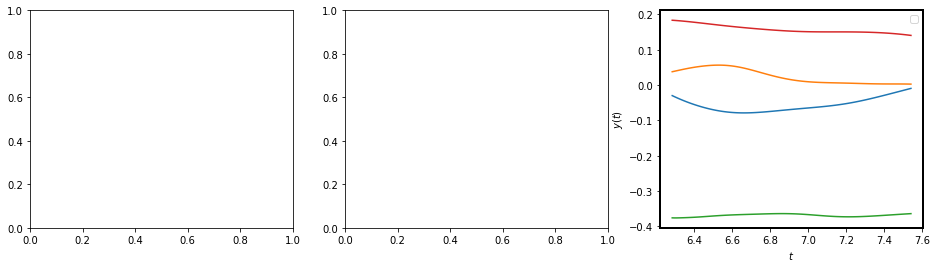

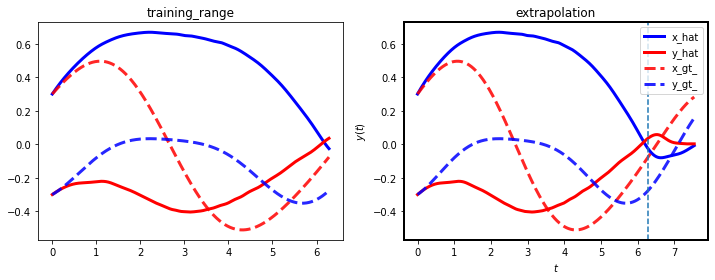

In [51]:
base = 2*np.pi#10*np.pi*0.6*0.7
extrapolate(esn,  0, base, base*1.2,
            init_conds = [0.3, -0.3, 0.3, 0.15], epochs = 1005)